# ROC Analysis Center
Welcome! This documentation covers the usage of the ROC curve analysis framework consisting of two main components:
1. `roc_analysis_project.ipynb` - A project-specific notebook for generating ROC curves that you should copy into your project-code folder
2. `wrapper_roc_analysis.py` - A centralized utility script with reusable functions

## Overview

This framework allows you to create, visualize, and statistically compare ROC curves from multiple machine learning models, scenarios, and cohorts. The system is designed with a centralized/distributed architecture:

- The **wrapper script** (`wrapper_roc_analysis.py`) contains all core functionality and is maintained centrally
- The **notebook** (`roc_analysis_project.ipynb`) can be copied to project-specific directories and customized while importing the centralized utilities

## Key Features

- Create ROC curves for multiple modeling scenarios across different cohorts
- Compare multiple estimator types (e.g., RFC vs XGB)
- Statistical comparison of ROC curves using DeLong's test
- Consistent visual styling with customizable color schemes
- Publication-ready figures in vector format (SVG)

## Getting Started

### Prerequisites

The framework requires a series of Python packages, including pandas, numpy, matplotlib, scikit-learn, scipy, seaborn, pyyaml
Additionally, it expects a project structure with model outputs in specific locations as defined in the notebook.

### Basic Usage

1. Copy the `roc_analysis_project.ipynb` notebook to your project directory
2. Ensure the `wrapper_roc_analysis.py` script is accessible in your Python path
3. Update file paths in the notebook to match your project structure
4. Run the notebook cells to generate ROC curves for your specific models

## Data Structure

The framework expects TPR (True Positive Rate) data in a specific format:
- An Excel/CSV file containing TPR values from cross-validation
- Data should be structured with columns representing different model configurations
- Column names should follow a specific naming convention: `{cohort}_{fold}_{scenario}_model{model_number}`

## Key Functions

### From `wrapper_roc_analysis.py`

#### Visualization Functions

- `plot_roc_curve()`: Creates a single ROC curve
- `plot_rocs()`: Plots multiple ROC curves with mean and standard deviation
- `plot_rocs_wrapper()`: Higher-level function to plot ROC curves for multiple scenarios
- `plot_rocs_multi_estimator()`: Compares ROC curves across different estimator types
- `plot_colorbar()`: Creates a color legend for scenario visualization

#### Statistical Functions

- `perform_delong_test()`: Executes DeLong's test to compare AUCs
- `delong_roc_test()`: Core implementation of DeLong's test
- `delong_roc_variance()`: Computes variance for DeLong's test

# Libraries and Functions

In [ ]:
import sys
import yaml
sys.path.append("../../modeling_pipeline") #Because the project is in a different folder (two levels up), we need to add the path to the sys path
sys.path.append("../..")

%load_ext autoreload
%autoreload 2

from modeling_pipeline.pipeline import * #Load our package with classes pipeline, models, pp (preprocessing), plot, and more
from wrapper_roc_analysis import *

#This allows us to automatically reload the packages we are working on in the background, no "Restart Kernel" needed



############### CHANGE THIS ############
path= pp.userpath(os.environ.get("USER", os.environ.get("USERNAME")), project="cca") # Choose your own project here, only works if you added specific project in user_settings.json
############### CHANGE THIS ############


fig_path = f"{path}/visuals"
auroc_path = f"{fig_path}/AUROCs"
if not os.path.exists(auroc_path):
    os.makedirs(auroc_path)

# Load the default color dictionary
yaml_colors_path = "custom_colors.yaml"
with open(yaml_colors_path, 'r') as file:
    config = yaml.safe_load(file)

scenarios_colors = config.get("scenarios_colors", {}) # Extract the color dictionary
print("Successfully loaded color dictionary with", len(scenarios_colors), "entries")

line_styles = config.get("line_styles", {}) # Extract the line styles dictionary
print("Successfully loaded line dictionary with", len(line_styles), "entries")

scenario_lists = config.get("scenario_lists", {}) # Extract the scenario lists
print("Successfully loaded list dictionary with", len(scenario_lists), "entries")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Successfully loaded color dictionary with 24 entries
Successfully loaded line dictionary with 6 entries
Successfully loaded list dictionary with 8 entries


# Customization

### Color Schemes

The framework uses a YAML file (`default_colors.yaml`) to define color schemes for different scenarios:

```yaml
scenarios_colors:
  A: '#8A2BE2'  # BlueViolet
  B: '#FF7F50'  # Coral
  C: '#20B2AA'  # LightSeaGreen
  # More colors...

### Scenarios

You can define different scenarios/constellations to plot in one model by changing these variables
scenario_lists:
  incremental: ['A', 'B', 'C', 'D', 'E']
  separate: ['Demographics', 'Diagnosis', 'Blood', 'SNP', 'Metabolomics']
  # More scenario groups...
```

You can also define custom colors directly in the notebook:

```python
my_colors = {
    'A': '#8A2BE2',  # BlueViolet
    'B': '#FF7F50',  # Coral
    # More colors...
}
```

# Data Import for Estimators

In [2]:
all_tprs = load_tprs(path,["RFC","CatBoost"])
all_preds = load_prediction_values(path, ["RFC","CatBoost"])

Loaded joblib TPRs for RFC
Loaded joblib TPRs for CatBoost
Loaded predictions for RFC_all_cca_Model_TOP5 from joblib from C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/Models/Pipelines/RFC\combined_output/val/Prediction_values_combined.joblib
Loaded predictions for RFC_all_cca_Model_TOP10 from joblib from C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/Models/Pipelines/RFC\combined_output/val/Prediction_values_combined.joblib
Loaded predictions for RFC_all_cca_Model_C from joblib from C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/Models/Pipelines/RFC\combined_output/val/Prediction_values_combined.joblib
Loaded predictions for RFC_all_cca_Model_A from joblib from C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/Models/Pipelines/RFC\combined_output/val/Prediction_values_combined.joblib
Loaded predictions for RFC_all_cca_Mod

Data Import of external TPRS and conversion to our structure

In [ ]:
aou_tprs = joblib.load("C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/tables_aou/TPRS_combined_RFC.joblib")
aou_tprs = aou_tprs.T
aou_tprs_multi_RFC = convert_to_multiindex(aou_tprs)

In [ ]:
aou_tprs = joblib.load("C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/tables_aou/TPRS_combined_CatBoost.joblib")

aou_tprs = aou_tprs.T
aou_tprs_multi_CatBoost = convert_to_multiindex(aou_tprs)
all_tprs = pd.concat([all_tprs, aou_tprs_multi_RFC], axis=0)
all_tprs = pd.concat([all_tprs, aou_tprs_multi_CatBoost], axis=0)


# OPTIONAL: You can also calculate the TPRS from the prediction values dictionary using this function
If you do not want to manipulate your pred values by subsetting e.g. you do not need this and can just stick to the tprs loader above



get one of the pred dataframes for the model you want to look at, then merge with your Sex info from a different dataframe by eid and then calculate the tprs afterwards


In [ ]:
single_model_preds = all_preds["CatBoost_all_cca_Model_TOP5"]

or just calculate it for the whole dataframe first and then access it afterwards


In [ ]:
calculated_dict = calculate_tprs_from_pred_val_dict(all_preds)


### Access the results

- `tprs_df = calculated_dict['tprs']`  
  Multi-Index DataFrame with TPRs for all model iterations.

- `aucs = calculated_dict['aucs']`  
  Dictionary with AUC scores for each model iteration.

- `auprcs = calculated_dict['auprcs']`  
  Dictionary with AUPRC scores for each model iteration.



In [ ]:
all_tprs = calculated_dict["tprs"]
all_aucs = calculated_dict["aucs"]
all_auprcs = calculated_dict["auprcs"]
all_raw_curves = calculated_dict["raw_curves"]

### Example: Get TPRs for all model iterations of this specific configuration
- `specific_tprs = tprs_df.loc[('all_cca', 'TOP5')]`  
  Returns all model iterations



In [ ]:
specific_tprs = all_tprs.loc[("all_cca", "TOP5")]

# Statistics

- `compare_estimators()`: Executes DeLong's test to compare AUCs of different estimators
- `compare_models()`: Executes DeLong`s test to compare AUCs of different models of the same estimator

In [3]:
delong_results_estimators = compare_estimators(
    all_tprs=all_tprs,
    cohorts=['unscreened_cca'],
    scenarios=["A", "B", "C", "D", "E"],
    estimators=[ 'RFC','CatBoost']
)
delong_results_estimators

,Cohort,Model,Estimator 1,Estimator 2,Z-statistic,p-value,Mean AUC Difference,SE of Difference,Bonferroni-adjusted p-value,Significant (α=0.05)
0,unscreened_cca,A,RFC,CatBoost,-3.4200,0.0006,-0.0102,0.0030,0.0030,True
1,unscreened_cca,B,RFC,CatBoost,-3.5779,0.0003,-0.0129,0.0036,0.0015,True
2,unscreened_cca,C,RFC,CatBoost,-2.2644,0.0235,-0.0116,0.0051,0.1175,False
3,unscreened_cca,D,RFC,CatBoost,0.5235,0.6006,0.0016,0.0031,1.0000,False
4,unscreened_cca,E,RFC,CatBoost,6.6988,0.0000,0.0581,0.0087,0.0000,True


In [11]:
delong_results_models = compare_models(
    all_tprs=all_tprs,
    cohorts=['unscreened_cca'],
    scenarios=["A", "B", "C", "D", "E"],
    estimator='RFC'
)


# AUROCs

### Example Workflows in the Notebook

The notebook contains several example workflows, applied to a variety of model constellations (e.g. incremental modalities, i.e from demographics to added diagnosis, added blood, added omics), iterative feature reduction with alpha-level indicating the amount of features, or assessing a number of different benchmarks

1. **Basic ROC comparison**: Compare ROC curves from different model scenarios
   ```python
   fig, ax = plt.subplots(figsize=(6, 5))
   plot_roc_curve(test_scores=benchmarks["aMAP"], true_labels=benchmarks.status, ax=ax)
   plot_rocs_wrapper(mapped_tprs, fig, ax, scenario_lists['incremental'], 'all',
                      title='All Patients', fig_type="AUROCS_combined")
   ```

2. **Literature benchmark comparison**: Compare your models against published benchmarks
   ```python
   fig, ax = plt.subplots(figsize=(6, 5))
   plot_roc_curve(test_scores=benchmarks["aMAP"], true_labels=benchmarks.status, ax=ax, label="aMAP")
   plot_roc_curve(test_scores=benchmarks["APRI"], true_labels=benchmarks.status, ax=ax, label="APRI")
   plot_roc_curve(test_scores=benchmarks["FIB4"], true_labels=benchmarks.status, ax=ax, label="FIB4")
   plot_rocs_wrapper(mapped_tprs, fig, ax, scenario_lists['c'], 'all',
                      title='Literature Benchmark', fig_type="AUROCS_combined")
   ```


3. **Multiple estimator comparison**: Compare different model types (RFC vs XGB)
   ```python
   plot_rocs_multi_estimator(
       all_tprs=all_tprs,
       scenario_list='incremental',
       cohorts=['all'],
       scenarios_colors=scenarios_colors,
       n_splits=5,
       fig_path=auroc_path,
       title='All Patients',
       fig_type="AUROCS_multi_Estimator"
   )
   ```

## Combined AUROCs (Incremental) for one estimator class

# Multiple Estimators Comparison

### Multi Estimator Comparison


This plots different ROC curves for different estimators, make sure you have run the same models for the different estimators so you don not get key errors

In [5]:
model_types = [ "RFC", "CatBoost"]

### All cohort


Saved figure as SVG to: C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/visuals/AUROCs\AUROC_Multi_Estimator__AUROC_Estimator_Comparison_Unscreened.svg


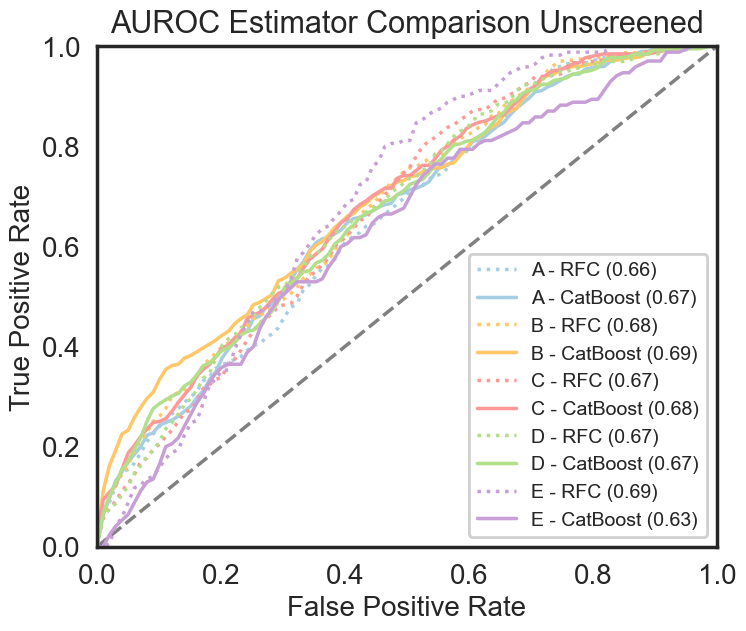

In [7]:
plot_rocs_multi_estimator(
    all_tprs=all_tprs,
    scenario_list= "incremental",
    model_types=model_types,
    cohorts=['unscreened_cca'],
    scenarios_colors=scenarios_colors,
    scenario_lists=scenario_lists,
    n_splits=5,
    fig_path=auroc_path,
    title='AUROC Estimator Comparison Unscreened',
    line_styles=None,
    font_size=20
)

### PAR cohort

In [ ]:
plot_rocs_multi_estimator(
    all_tprs=all_tprs,
    scenario_list= "incremental",
    model_types=model_types,
    cohorts=['par_cca'],
    scenarios_colors=scenarios_colors,
    scenario_lists=scenario_lists,
    n_splits=5,
    fig_path=auroc_path,
    title='Auroc Estimator Comparison ',
    line_styles=None,
    font_size=20
)